In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Dados Históricos 10 anos- Ibovespa.csv')
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2227,01.07.2016,52.233,51.540,52.346,51.411,"4,24M","1,37%"
2228,30.06.2016,51.527,51.001,51.619,50.585,"4,51M","1,03%"
2229,29.06.2016,51.002,50.009,51.229,50.009,"4,09M","1,99%"
2230,28.06.2016,50.007,49.252,50.301,49.252,"3,51M","1,55%"
2231,27.06.2016,49.246,50.106,50.162,48.954,"3,33M","-1,71%"


In [3]:
df.shape

(2232, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2232 non-null   object 
 1   Último    2232 non-null   float64
 2   Abertura  2232 non-null   float64
 3   Máxima    2232 non-null   float64
 4   Mínima    2232 non-null   float64
 5   Vol.      2232 non-null   object 
 6   Var%      2232 non-null   object 
dtypes: float64(4), object(3)
memory usage: 122.2+ KB


In [5]:
df.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

In [6]:
#mudando os nomes das colunas
colunas = {
    'Data': 'data',
    'Último': 'ultimo', # último valor registrado no dia
    'Abertura':'abertura', # valor inicial do dia 
    'Máxima':'maxima', # valor máximo do dia
    'Mínima':'minima', # valor mínimo do dia
    'Vol.':'volume', # quantidade de negociação
    'Var%': 'variacao_percentual' # variação percentual
}

df.rename(columns=colunas, inplace=True)
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao_percentual
0,24.06.2025,137.165,136.552,138.156,136.254,"8,08B","0,45%"
1,23.06.2025,136.551,137.116,137.130,135.835,"7,73B","-0,41%"
2,20.06.2025,137.116,138.715,138.719,136.815,"11,29B","-1,15%"
3,18.06.2025,138.717,138.844,139.161,138.443,"8,32B","-0,09%"
4,17.06.2025,138.840,139.256,139.497,138.293,"8,38B","-0,30%"


In [7]:
# foi observado que a coluna data está no formato object
df['data'] = pd.to_datetime(df['data'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   data                 2232 non-null   datetime64[ns]
 1   ultimo               2232 non-null   float64       
 2   abertura             2232 non-null   float64       
 3   maxima               2232 non-null   float64       
 4   minima               2232 non-null   float64       
 5   volume               2232 non-null   object        
 6   variacao_percentual  2232 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 122.2+ KB


C:\Users\luish\AppData\Local\Temp\ipykernel_11688\1235484158.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['data'] = pd.to_datetime(df['data'])


In [8]:
df.isnull().sum()

data                   0
ultimo                 0
abertura               0
maxima                 0
minima                 0
volume                 0
variacao_percentual    0
dtype: int64

In [9]:
# volume está com , ao invés de '.' e com valores resumidos a K(mil), M(milhão), B(bilhão)
df['volume']

0        8,08B
1        7,73B
2       11,29B
3        8,32B
4        8,38B
         ...  
2227     4,24M
2228     4,51M
2229     4,09M
2230     3,51M
2231     3,33M
Name: volume, Length: 2232, dtype: object

In [10]:
#ajustando a coluna volume
def limpando_volume(volume):
        if 'K' in volume:
            return float(volume.replace('K', '').replace(',', '.')) * 1_000
        elif 'M' in volume:
            return float(volume.replace('M', '').replace(',', '.')) * 1_000_000
        else:
            return float(volume.replace('B', '').replace(',', '.')) * 1_000_000_000
        

df['volume'] = df['volume'].apply(limpando_volume)
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao_percentual
0,2025-06-24,137.165,136.552,138.156,136.254,8.080000e+09,"0,45%"
1,2025-06-23,136.551,137.116,137.130,135.835,7.730000e+09,"-0,41%"
2,2025-06-20,137.116,138.715,138.719,136.815,1.129000e+10,"-1,15%"
3,2025-06-18,138.717,138.844,139.161,138.443,8.320000e+09,"-0,09%"
4,2025-06-17,138.840,139.256,139.497,138.293,8.380000e+09,"-0,30%"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   data                 2232 non-null   datetime64[ns]
 1   ultimo               2232 non-null   float64       
 2   abertura             2232 non-null   float64       
 3   maxima               2232 non-null   float64       
 4   minima               2232 non-null   float64       
 5   volume               2232 non-null   float64       
 6   variacao_percentual  2232 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 122.2+ KB


In [12]:
#ajustando a coluna variacao_percentual
df['variacao_percentual'] = df['variacao_percentual'].astype(str).str.replace('%', '', regex=False).str.replace(',', '.')
df['variacao_percentual'] = df['variacao_percentual'].astype(float)/100
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao_percentual
0,2025-06-24,137.165,136.552,138.156,136.254,8.080000e+09,0.0045
1,2025-06-23,136.551,137.116,137.130,135.835,7.730000e+09,-0.0041
2,2025-06-20,137.116,138.715,138.719,136.815,1.129000e+10,-0.0115
3,2025-06-18,138.717,138.844,139.161,138.443,8.320000e+09,-0.0009
4,2025-06-17,138.840,139.256,139.497,138.293,8.380000e+09,-0.0030


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   data                 2232 non-null   datetime64[ns]
 1   ultimo               2232 non-null   float64       
 2   abertura             2232 non-null   float64       
 3   maxima               2232 non-null   float64       
 4   minima               2232 non-null   float64       
 5   volume               2232 non-null   float64       
 6   variacao_percentual  2232 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 122.2 KB


In [14]:
df = df.sort_values('data').reset_index(drop=True)
df['ultimo_amanha'] = df['ultimo'].shift(-1)
df['tendencia'] = (df['ultimo_amanha'] > df['ultimo']).astype(int)
df.dropna(subset=['ultimo_amanha', 'tendencia'], inplace=True) # Removendo a última linha 

df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao_percentual,ultimo_amanha,tendencia
0,2016-06-27,49.246,50.106,50.162,48.954,3330000.0,-0.0171,50.007,1
1,2016-06-28,50.007,49.252,50.301,49.252,3510000.0,0.0155,51.002,1
2,2016-06-29,51.002,50.009,51.229,50.009,4090000.0,0.0199,51.527,1
3,2016-06-30,51.527,51.001,51.619,50.585,4510000.0,0.0103,52.233,1
4,2016-07-01,52.233,51.540,52.346,51.411,4240000.0,0.0137,52.569,1


In [15]:
df['variacao_percentual'].describe()

count    2231.000000
mean        0.000558
std         0.014671
min        -0.147800
25%        -0.006700
50%         0.000800
75%         0.008350
max         0.139100
Name: variacao_percentual, dtype: float64

In [16]:
df.tail(21) 

,data,ultimo,abertura,maxima,minima,volume,variacao_percentual,ultimo_amanha,tendencia
2210,2025-05-23,137.824,137.273,137.824,134.997,1.068000e+10,0.0040,138.136,1
2211,2025-05-26,138.136,137.824,138.800,137.795,5.550000e+09,0.0023,139.541,1
2212,2025-05-27,139.541,138.136,140.382,138.136,1.119000e+10,0.0102,138.888,0
2213,2025-05-28,138.888,139.541,139.547,138.580,9.730000e+09,-0.0047,138.534,0
2214,2025-05-29,138.534,138.869,139.108,137.993,8.830000e+09,-0.0025,137.027,0
2215,2025-05-30,137.027,138.546,138.637,136.726,1.514000e+10,-0.0109,136.787,0
2216,2025-06-02,136.787,137.026,138.471,136.483,9.100000e+09,-0.0018,137.546,1
2217,2025-06-03,137.546,136.787,137.672,136.175,9.700000e+09,0.0056,137.002,0
2218,2025-06-04,137.002,137.547,138.797,136.695,1.020000e+10,-0.0040,136.236,0
2219,2025-06-05,136.236,137.003,137.451,136.031,9.480000e+09,-0.0056,136.102,0


In [17]:
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao_percentual,ultimo_amanha,tendencia
0,2016-06-27,49.246,50.106,50.162,48.954,3330000.0,-0.0171,50.007,1
1,2016-06-28,50.007,49.252,50.301,49.252,3510000.0,0.0155,51.002,1
2,2016-06-29,51.002,50.009,51.229,50.009,4090000.0,0.0199,51.527,1
3,2016-06-30,51.527,51.001,51.619,50.585,4510000.0,0.0103,52.233,1
4,2016-07-01,52.233,51.540,52.346,51.411,4240000.0,0.0137,52.569,1


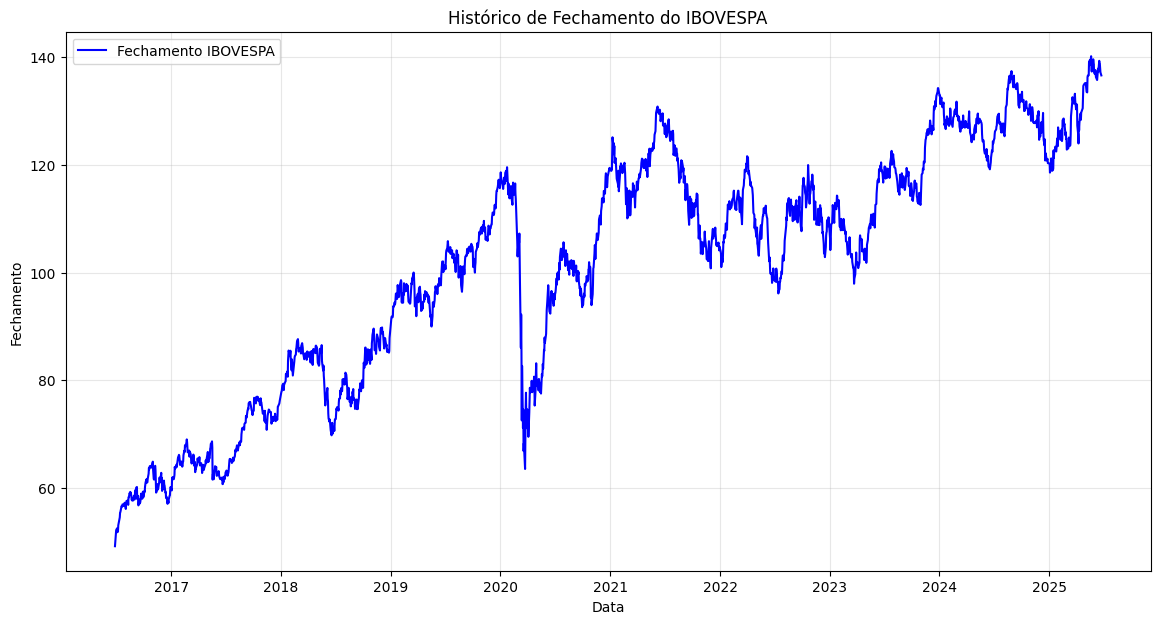

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(df['data'], df['ultimo'], label='Fechamento IBOVESPA', color='blue')
plt.title('Histórico de Fechamento do IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.grid(True, alpha = 0.3)
plt.legend()


([<matplotlib.axis.XTick at 0x1954ac13390>,
 [Text(0, 0, 'Baixa'), Text(1, 0, 'Alta')])

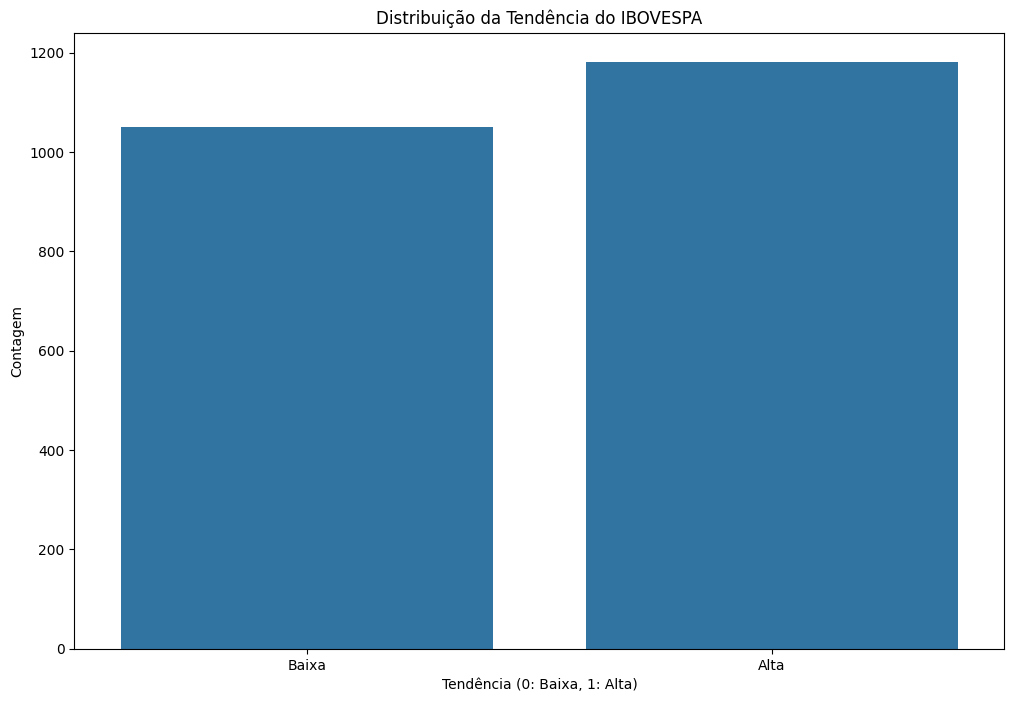

In [ ]:
# Fazendo um plot da possível variável alvo para ver as quantidades de dias que terminou em alta / baixa
plt.figure(figsize=(12, 8))
sns.countplot(x='tendencia', data=df)
plt.title('Distribuição da Tendência do IBOVESPA')
plt.xlabel('Tendência (0: Baixa, 1: Alta)')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Baixa', 'Alta'])